202311_jedha_bloc3_ChallengeML
Beraud Mélanie

www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !


# Import libraries

In [1]:
import pandas as pd
import numpy as np

# Preprocessing

#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


from plotly.subplots import make_subplots
# Ma palette pour les plotly
pio.templates["mel_purple"] = go.layout.Template(
    layout_colorway=['#FF34B3', '#CD2990', '#8B1C62', '#CD00CD', '#8B008B', '#8968CD', '#5D478B','#20B2AA']) #'#EEA2AD', trop proche

pio.templates.default = "mel_purple"
pio.renderers.default = 'notebook_connected' # to be replaced by "iframe_connected" to have the pictures in files

from IPython.display import display

# Functions

In [2]:
# Preprocessing function:
def prepare_datasets(donnees, name_dataset):

    ''' 
    Should be given:
    * data to process
    * name for the dataset in ''
    The function will prepare Features X/Target Y datatsets, train/val subsets: Splitting and Preprocessing
    And return (in that order):
        * 4 preprocessed datasets (X_train, X_val, y_train, y_val) 
        * list of names for num features, cat features from input dataset
        * name of X_train/X_val columns
        * the name of the dataset for log
    '''
    name_dataset = name_dataset

    X = donnees.drop('converted', axis = 1)
    Y = donnees.loc[:, 'converted']
    print(type(X), X.shape, type(Y), Y.shape)

    # Train_val split
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
    #X_train[0:5], y_val[0:5]

    # Recovery features category_name
    num_features = []
    cat_features = []

    for col in X_train:
        if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64':
            num_features.append(col)
        else:
            cat_features.append(col)

    num_features = num_features
    print(f'num_features are:{num_features},\ncat_features are:{cat_features}')

    # Preprocessings
    norm = StandardScaler()
    encod = OneHotEncoder(drop="first")

    preprocesseur = ColumnTransformer(transformers=[
    ('num', norm, num_features),
    ('cat', encod, cat_features)])
    
    X_train = preprocesseur.fit_transform(X_train)
    X_val = preprocesseur.transform(X_val)

    # recovery of columns names in X_train and X_val
    liste_features_name = []    
    for name in preprocesseur.get_feature_names_out():
        liste_features_name.append(name[5:])
    #print(liste_features_name, liste_features_name[0], liste_features_name[1])

    print (f'Dataset {name_dataset} is ready.')

    return X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset
    #X_train[0:5], y_train[0:5], X_val[0:5], y_val[0:5], y_train.value_counts(), y_val.value_counts()

# X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full')

def model_scores(name_model, model, name_dataset):
    
    ''' 
    Should be given:
    * name you want to give your model as name_model in ''
    * name of the model as a variable_should be gridsearch_Best_estimators_ if gridsearch
    * name of the dataset. You can use name_dataset from the preprocessing

    The function will return in a dataframe:
    * the accuracy for train and val, 
    * the prediction, 
    * the f1 score for train and val,
    * the full parameters of the classifier
    * the coefficients, 
    * the confusion matix, 
    * the classification report 
    and put everything in a dataframe that can be called.

    It will also display a few intersting tables...
    '''

    name_model = name_model
    name_dataset = name_dataset
    model = model

    # Predictions

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    #scores
    accuracy_train = model.score(X_train, y_train)
    accuracy_val = model.score(X_val, y_val)

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)


    parametres = model.get_params()
    try:
        coefficients = [coef for coef in model.coef_]
    except:
        coefficients =[]
        
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_val, y_val_pred)

    print('classification report train')
    print(report_train)
    print('classification report val')
    print(report_val)

    # Confusion matrix
    tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
    fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

    tn_train, fp_train = confusion_matrix(y_train, y_train_pred)[0,0], confusion_matrix(y_train, y_train_pred)[0,1]
    fn_train, tp_train = confusion_matrix(y_train, y_train_pred)[1,0], confusion_matrix(y_train, y_train_pred)[1,1]
    
    #tn_val, fp_val, fn_val, tp_val

    #Confusion matrix    
    print('matrices de confusion')
    fig_train , ax1 = plt.subplots()
    ax1.set(title="Confusion Matrix on Train set") 
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax1) 
    fig_train.show('notebook_connected')

    fig_val , ax2 = plt.subplots()
    ax2.set(title="Confusion Matrix on val set") 
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, ax=ax2) 
    fig_val.show() 

    report = [name_model, model, name_dataset,  parametres, 
              accuracy_train, accuracy_val, coefficients, 
              y_train_pred, y_val_pred, f1_train, f1_val, 
              tn_val, fp_val, fn_val, tp_val,
              tn_train, fp_train, fn_train, tp_train,
              report_train, report_val]

    

    dataf  = pd.DataFrame(data=[], columns = ['name_model', 'model', 'name_dataset',  'parametres', 
              'accuracy_train', 'accuracy_val', 'coefficients', 
              'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 
              'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train',
              'report_train', 'report_val'])
    

      
    
    dataf.loc[len(dataf), :] = report

    '''
    # model.get_params().__getitem__('C')

    coeff= pd.DataFrame(test['coefficients'][0])
    coeff
    '''
    # presentation
    liste_scores = ['name_model', 'model', 'name_dataset', 'accuracy_train', 'accuracy_val', 'f1_train', 'f1_val']
    liste_confusionMatrix = ['name_model', 'model', 'name_dataset', 'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train']
    liste_params = ['name_model', 'model', 'name_dataset',  'parametres', 'coefficients']

 
    scores = dataf.loc[:, liste_scores]
    confusion = dataf.loc[:, liste_confusionMatrix]
    parametre = dataf.loc[:, liste_params]
    # adapter les parametre selon le type de modèle... et les coeff selon le nb de coeff


    display(scores, confusion, parametre)
    print(f'This function returns a Reporting DataFrame composed of:\n   {[col for col in dataf.columns]}')

    
    return dataf
#resultats_df = model_scores('name_model', model, name_dataset)

def nom_variable(str):
    return str


# Import data

In [21]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)


# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

final_scoring = pd.read_csv('final_scoring.csv')
final_scoring

Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB


,name_model,model,name_dataset,parametres,accuracy_train,accuracy_val,coefficients,y_train_pred,y_val_pred,f1_train,...,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train,report_train,report_val
0,reglog_full,LogisticRegression(),full,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
1,reglog_country,LogisticRegression(),country,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
2,reglog_age,LogisticRegression(),age,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
3,reglog_new_user,LogisticRegression(),new_user,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
4,reglog_source,LogisticRegression(),source,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
5,reglog_total_pages_visited,LogisticRegression(),total_pages_visited,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
6,reglog_converted,LogisticRegression(),converted,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,54855,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...
7,reglog_gs,LogisticRegression(C=0.1),full,"{'C': 0.1, 'class_weight': None, 'dual': False...",0.986318,0.985628,"[array([-0.5864657 , 2.51598049, 2.66063539,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.764390,...,54855,225,593,1243,219496,824,2291,5053,precision recall f1-score ...,precision recall f1-score ...
8,reglog_ada_gs,AdaBoostClassifier(estimator=LogisticRegressio...,full,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.985110,0.984310,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.735693,...,54866,214,679,1157,219556,764,2626,4718,precision recall f1-score ...,precision recall f1-score ...
9,bag_tree_gs,BaggingClassifier(estimator=DecisionTreeClassi...,full,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.984543,0.984205,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.729245,...,54846,234,665,1171,219406,914,2605,4739,precision recall f1-score ...,precision recall f1-score ...


In [46]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False) 

In [84]:
data.head()

'''
data.columns
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

"\ndata.columns\nIndex(['country', 'age', 'new_user', 'source', 'total_pages_visited',\n       'converted'],\n      dtype='object')\n"

In [85]:
data.describe(include = 'all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.0,284580,284580.000000,284580.000000
unique,4,NaN,2.0,3,NaN,NaN
top,US,NaN,1.0,Seo,NaN,NaN
freq,160124,NaN,195066.0,139477,NaN,NaN
mean,NaN,30.564203,NaN,NaN,4.873252,0.032258
std,NaN,8.266789,NaN,NaN,3.341995,0.176685
min,NaN,17.000000,NaN,NaN,1.000000,0.000000
25%,NaN,24.000000,NaN,NaN,2.000000,0.000000
50%,NaN,30.000000,NaN,NaN,4.000000,0.000000
75%,NaN,36.000000,NaN,NaN,7.000000,0.000000


In [86]:
# No need anymore ...

data.info() # No Null values
data.new_user.astype('category')
data.info()

for col in data.columns:
    print(col, data[col].value_counts(dropna=False))

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-nul

# EDA

In [87]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample.new_user = data_sample.new_user.astype('category')
data_sample.dtypes

#TO WORK without importing dataset
data_sample.to_csv('data_sample.csv') 

In [88]:
data_sample.new_user.value_counts(dropna=False)

new_user
1    6844
0    3156
Name: count, dtype: int64

In [89]:
data_sample = pd.read_csv('data_sample.csv', index_col=0)
data_sample.new_user = data.new_user.astype('category')

'''
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

data_sample.info()

# recovery of num features and cat features
num_features = []
cat_features = []

for col in data_sample:
    if data_sample[col].dtypes == 'int64' or data_sample[col].dtypes == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

num_features = num_features[:-1]
num_features, cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 186736 to 274551
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   country              10000 non-null  object  
 1   age                  10000 non-null  int64   
 2   new_user             10000 non-null  category
 3   source               10000 non-null  object  
 4   total_pages_visited  10000 non-null  int64   
 5   converted            10000 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 478.6+ KB


(['age', 'total_pages_visited'], ['country', 'new_user', 'source'])

In [90]:
data_sample.new_user.value_counts(dropna=False)

new_user
1    6844
0    3156
Name: count, dtype: int64

In [91]:
# Pairwise dependencies _ no need here
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [92]:
data_sample.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.0,10000,10000.000000,10000.000000
unique,4,NaN,2.0,3,NaN,NaN
top,US,NaN,1.0,Seo,NaN,NaN
freq,5691,NaN,6844.0,4915,NaN,NaN
mean,NaN,30.493800,NaN,NaN,4.841200,0.033700
std,NaN,8.238249,NaN,NaN,3.342798,0.180465
min,NaN,17.000000,NaN,NaN,1.000000,0.000000
25%,NaN,24.000000,NaN,NaN,2.000000,0.000000
50%,NaN,30.000000,NaN,NaN,4.000000,0.000000
75%,NaN,36.000000,NaN,NaN,6.000000,0.000000


In [93]:
data_sample.new_user.value_counts(dropna=False)


new_user
1    6844
0    3156
Name: count, dtype: int64

In [94]:

''' Nope... sert à en mettre plusieurs à côté
fig, ax = plt.subplots(1,2, figsize=(20, 10))
for axi in ax.flatten():  # enumerate - 0 pour histogramme et 1 box
    axi.hist(data_sample[col])
'''

for col in num_features:
    fig = make_subplots(rows = 1, cols = 2)#, figsize=[10,20])

    fig.add_trace(px.histogram(data_sample[col]).data[0], row = 1, col=1)
    fig.add_trace(px.box(data_sample[col]).data[0], row = 1, col=2)
    fig.update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
                    showlegend=False, width=800, height =400)
    #fig.show('iframe_connected') #only the last one :()
    display(fig)

   
    # ne fonctionne pas avec fig, axs & ax[0], ou ax[0,0], ne fonctionne pas avec fig, '(ax1, ax2) et ax1= 


for col in cat_features:
    fig = px.histogram(data_sample[col], title=f'Distribution {col}')
    fig.update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
                    showlegend=False, width=800, height =400)
    display(fig)




In [8]:
data.age.mean(), data.age.max()
fig = px.histogram(data.age)

fig = px.histogram(data.age[data['age']>60])
display(fig)
fig.show('notebook_connected')
# Garder en tête : Il y a des ousiders en age : 110 et 120 ans

### Garder en tête : Il y a des ousiders en age : 110 et 120 ans. Record reconnu de tous les ltemps : Jeanne Calmant 121 ans.

In [96]:
# useless  on only 2 num_features...
temp = data.loc[:,num_features]
corr_matrix = temp.corr().round(2)

corr_matrix


,age,total_pages_visited
age,1.00,-0.05
total_pages_visited,-0.05,1.00


In [ ]:
# doesn't work

'''
import ipywidgets as ipw

VBox([HBox([fw1, fw2]), HBox([fw3])])
'''

fig2 = make_subplots(rows = 1, cols = 3) # doesnt' work

for col in cat_features:
    
    #gra = px.histogram(data_sample[col], title=f'Distribution {col}')
    #fig2.get_subplot(row = 1, col = 1, subplots = gra)
    #fig2 =  ipw.HBox([gra])                  
    fig2.add_traces(px.histogram(data_sample[col]), rows = 0, cols =1)#, title=f'Distribution {col}')
    #update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
#                    showlegend=False, width=800, height =400)
fig2.show()

### Preprocessing before separation :
No NaN, encoding cat = ok
### Preprocessing after separation:
OneHotEncoder for 3 cat, norm for 2 num

# First model

In [ ]:
print(X_train.age[0:5], X_val.age[0:5], X_train.columns, X_val.columns)

# Preprocessings
norm = StandardScaler()
encod = OneHotEncoder(drop="first")

preprocesseur = ColumnTransformer(transformers=[
('num', norm, num_features),
('cat', encod, cat_features)])

X_train = preprocesseur.fit_transform(X_train)
X_val = preprocesseur.transform(X_val)

print(X_train[0:5], X_val[0:5]) # ok

In [ ]:

corr_matrix = X.corr().round(2) # doesn't work
#import plotly.figure_factory as ff
'''
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()
temp = corr(data)
'''
corr_matrix


In [ ]:
liste_features_name = []
'''
array(['num__age', 'num__total_pages_visited', 'cat__country_China',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__new_user_0', 'cat__new_user_1', 'cat__source_Ads',
       'cat__source_Direct', 'cat__source_Seo'], dtype=object)
'''
for name in preprocesseur.get_feature_names_out():
       liste_features_name.append(name[5:])

liste_features_name, liste_features_name[0], liste_features_name[1]


(['age',
  'total_pages_visited',
  'country_Germany',
  'country_UK',
  'country_US',
  'new_user_1',
  'source_Direct',
  'source_Seo'],
 'age',
 'total_pages_visited')

In [ ]:
train_sample = pd.DataFrame(X_train[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
val_sample = pd.DataFrame(X_val[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
#val_sample.head()

print(train_sample.shape, val_sample.shape)


fig = make_subplots(rows = 1, cols = 4)#, figsize=[10,20])

fig.add_trace(px.histogram(train_sample[liste_features_name[0]]).data[0], row = 1, col=1)
fig.add_trace(px.histogram(train_sample[liste_features_name[1]]).data[0], row = 1, col=2)
fig.add_trace(px.histogram(val_sample[liste_features_name[0]]).data[0], row = 1, col=3)
fig.add_trace(px.histogram(val_sample[liste_features_name[1]]).data[0], row = 1, col=4)
fig.update_layout(showlegend=False, width=1200, height =400)


display(fig)


Prendre les attributs 1 à 1 ne hange rien

## Training pipeline

In [33]:
# First model

classifier = LogisticRegression() # 
classifier.fit(X_train, y_train)

list_params = classifier.get_params()
print(list_params)

classifier.score(X_train, y_train)
print(f"\nX_train accuracy:{classifier.score(X_train, y_train)},\n\
X_val accuracy:{classifier.score(X_val, y_val)}\n")

# Predictions & F1
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

print(f'X_train F1:{f1_score(y_train, y_train_pred)},\n\
X_val F1:{f1_score(y_val,y_val_pred)}')

# coeff importance:
print('Features_importance:')
feat_imp = pd.DataFrame([coef for coef in classifier.coef_], columns=liste_features_name)
feat_imp

temp = feat_imp.transpose()
fig = px.bar(temp, x = abs(temp[0]), orientation='h', color=temp[0])
fig.update_layout(showlegend=False, title=f'Feature importance', font=dict(size=15), title_font_color="#8B1C62", margin=dict(l=150, r=20, t=50, b=40))
fig.update_yaxes(title = None)
fig.show()

# Confusion matrix

tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

#tn_val, fp_val, fn_val, tp_val

print('Confusion Matrix:')
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_val, y_val, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

X_train accuracy:0.9863307330100499,
X_val accuracy:0.9857685009487666

X_train F1:0.7654507084715104,
X_val F1:0.7554347826086957
Features_importance:


ValueError: not enough values to unpack (expected 4, got 2)

### Most important features 
seems to be The number of pages visited (positive correlation) and the country, the new user variable
Impact of sources is not that important, age neither.

### scores
F1 and accracy scores are basically the same for train and test

### Confusion matrice:
30% errors ont the positives labels (30% have been predicted as negative)
15% predicted neg should be true.

We need to work on the 30% errors...
Try with a gradient ?



# Data

### Datasets - Splitting, Preprocessing

In [4]:
# all columns = 'full'
data
X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full') 


<class 'pandas.core.frame.DataFrame'> (284580, 5) <class 'pandas.core.series.Series'> (284580,)
num_features are:['age', 'total_pages_visited'],
cat_features are:['country', 'new_user', 'source']
Dataset full is ready.


In [9]:
# Take the interesting Features... 40min....
# Define parameter space
eps_values = [0.2, 0.5, 0.8, 1, 1.2, 1.5] # qu'est ce que ça mesure ? epsilon, c'est la densité...
min_samples_values = [50,100,150,200] # c'est le nombre de voisin... j'aurais dû tester avec moins...
metrics = ["cityblock", "euclidean", "manhattan"]
# Grid search
best_score = -1
best_params = {'eps': None, 'min_samples': None, 'metric': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            db.fit(X_train)
            labels = db.labels_

            # Continue if all data is considered as noise
            if len(set(labels)) == 1:
                continue

            try:
                score = silhouette_score(X_train, labels)
            except:
                print("Not enough labels")
            if score > best_score and len(np.unique(labels)) >=3:
                best_score = score
                best_labels_unique, best_labels_count = np.unique(labels,return_counts=True)
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples
                best_params['metric'] = metric

# Best parameters
print("Best silhouette score:", best_score)
print("Best parameters:", best_params)
print("Unique labels:", best_labels_unique)
print("Count of labels:", best_labels_count)

Not enough labels


In [ ]:
silhouette_score(X_train, db.labels_)

db = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric=best_params['metric'])
db.fit(X)
labels = db.labels_

In [ ]:
# check features avec le plottree
# Perform grid search
decision_tree = DecisionTreeClassifier()

# importer le final scoring
# Grid of values to be tested
params = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
}

tree_simple_gs_m = GridSearchCV(decision_tree, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
tree_simple_gs_m .fit(X_train, y_train)

tree_simple_gs = model_scores('tree_simple_gs', tree_simple_gs_m.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,tree_simple_gs])
print(f'tree_simple = {tree_simple_gs_m.best_estimator_.params[0]}')



sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

# peut être fait avec DBScan, mais ce serait triché en ML Supervised

parametres_tree = [i for i in final_scoring.loc[final_scoring['name_model']=='tree_simple_gs', 'parametres']]
print(parametres_tree)
#tree_simpl_gs = 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2

0.7445386982959238 0.7360818537466145


Text(0.5, 1.0, "DecisionTreeClassifier(criterion='log_loss', max_depth=5)")

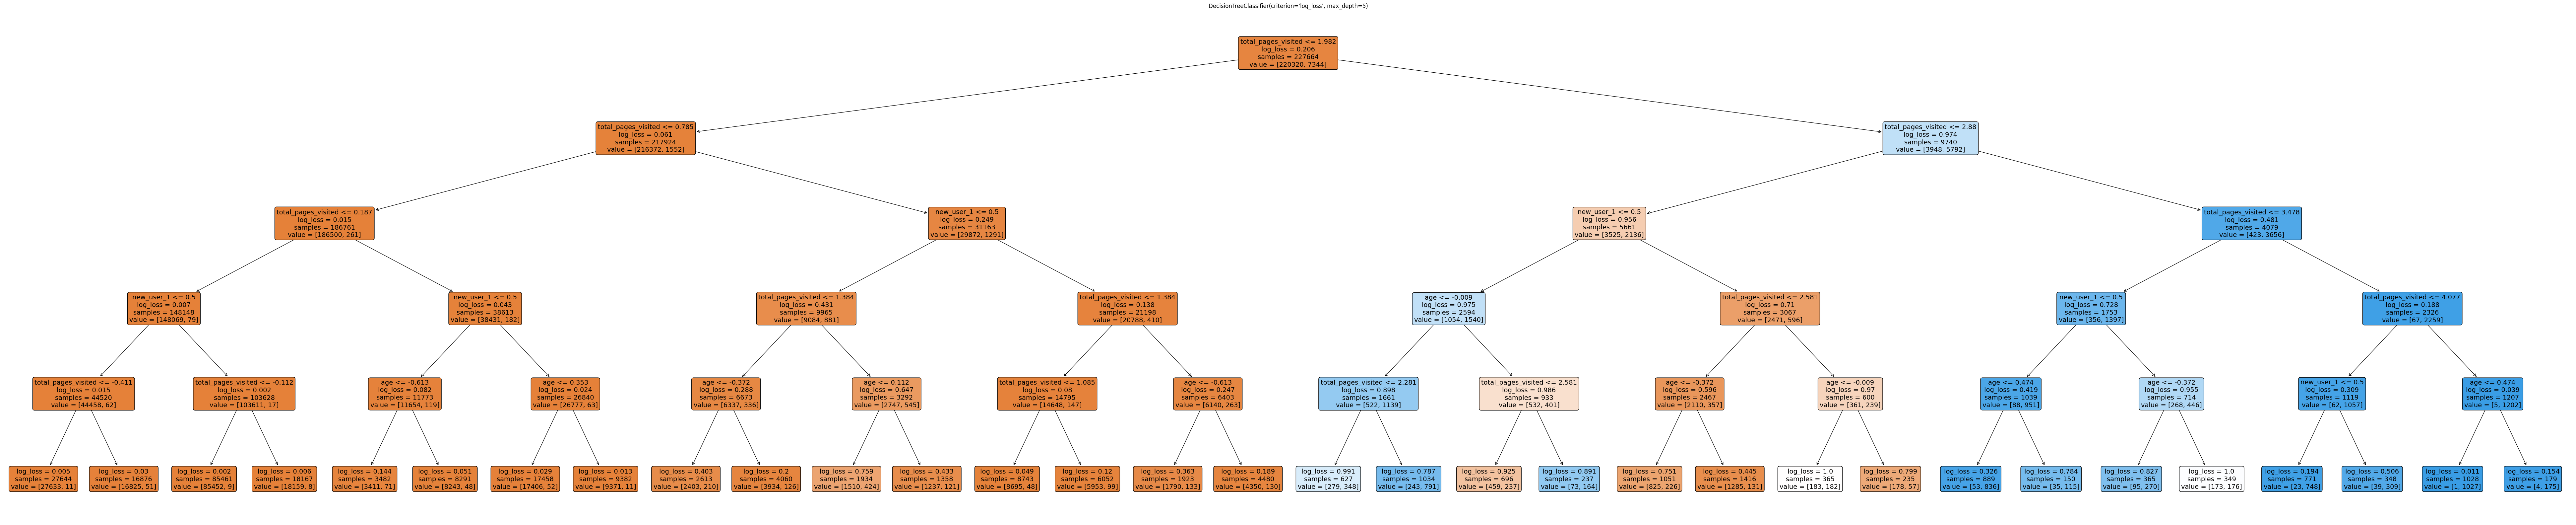

In [44]:
# check features avec le plottree
decision_tree_gini = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, criterion='gini')
#0.7504698894819939 0.7332733273327334
decision_tree_ent = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 1, min_samples_split = 2, criterion='entropy')
#0.7445386982959238 0.7360818537466145
decision_tree_log = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 1, min_samples_split = 2, criterion='log_loss')
#0.7445386982959238 0.7360818537466145


model = decision_tree_log

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(f1_score(y_train, y_train_pred), f1_score(y_val, y_val_pred))

plt.figure(figsize=(100,20))
a = plot_tree(model, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(model)


In [29]:
from sklearn.tree import plot_tree

#class_names = encoder.inverse_transform([0, 1, 2])

plt.figure(figsize=(20,20))
a = plot_tree(tree_simple_gs_m, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]}) instead.

<Figure size 2000x2000 with 0 Axes>

# Models

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

### Regression Logistique

In [ ]:
classifier = LogisticRegression() # 
classifier.fit(X_train, y_train)

#list_params = classifier.get_params()
#print(list_params)

reglog_full = model_scores('reglog_full', classifier, 'full')
final_scoring = reglog_full
final_scoring

In [ ]:


for col in data.columns:
    X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, col)
    classifier = LogisticRegression() 
    classifier.fit(X_train, y_train)

    temp = model_scores(nom_variable('reglog_'+ col), classifier, name_dataset)
    final_scoring= pd.concat([final_scoring,temp])
    


### Pas de différence de F1 ni de confusion matrix avec 1 seule colonne en reglog
## reglog - Gridsearch

In [ ]:
# Paramètres reglog - Gridsearch

logreg = LogisticRegression()

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0]
}
reglog_opt = GridSearchCV(logreg, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
reglog_opt.fit(X_train, y_train)

reglog_gs = model_scores('reglog_gs', reglog_opt.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,reglog_gs])

reglog_gs.parametres[0]

#reglog_gs.parametres[0] 
''' 
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

'''


In [31]:
#reglog_gs.parametres # 'C': 0.1
reglog_gs.parametres[0]
#classification_report(y_train, y_train_pred)

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Boosting_reg_logistique
*AdaBoost (Boost s'entraine là où le modèle précédent s'est planté)


In [ ]:
### AdaBoost

logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
reglog_ada = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
reglog_ada_gs = GridSearchCV(reglog_ada, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
reglog_ada_gs.fit(X_train, y_train)

reglog_ada_gs = model_scores('reglog_ada_gs', reglog_ada_gs.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,reglog_ada_gs])
print(f'Adaboost_best_params = {reglog_ada_gs.parametres[0]}')

#Adaboost_best_params = {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__C': 0.5, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 1000, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=0.5, max_iter=1000), 'learning_rate': 1.0, 'n_estimators': 30, 'random_state': None}

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')



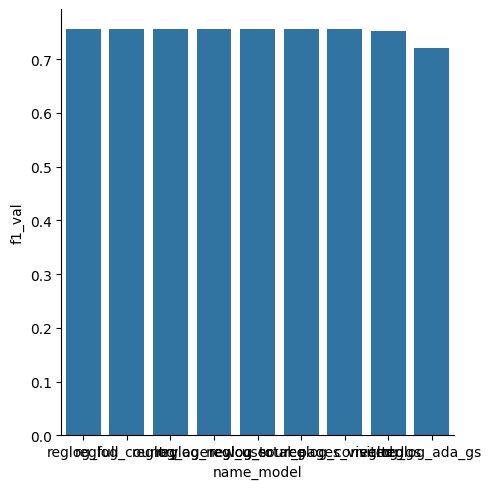

In [38]:

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

### Decision Tree
* BaggingClassifier ou Randeom Forest
* XGboost XGBoost (prédit l'ereur du précédent) - que decision treses
* Adaboost

{'base_estimator__max_depth': [2, 3, 4, 5], 'base_estimator__min_samples_leaf': [1, 2], 'base_estimator__min_samples_split': [2, 3], 'n_estimators': [3, 4, 5]}


/home/mel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/mel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/mel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/mel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/mel/.local

classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.83      0.68      0.75      7344

    accuracy                           0.99    227664
   macro avg       0.91      0.84      0.87    227664
weighted avg       0.98      0.99      0.98    227664

classification report val
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.82      0.67      0.74      1836

    accuracy                           0.98     56916
   macro avg       0.90      0.83      0.86     56916
weighted avg       0.98      0.98      0.98     56916

matrices de confusion


/tmp/ipykernel_18663/3724939990.py:128: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_18663/3724939990.py:133: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,name_model,model,name_dataset,accuracy_train,accuracy_val,f1_train,f1_val
0,bag_tree_gs,"(DecisionTreeClassifier(max_depth=5, min_sampl...",full,0.985373,0.984503,0.750412,0.73577


,name_model,model,name_dataset,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train
0,bag_tree_gs,"(DecisionTreeClassifier(max_depth=5, min_sampl...",full,54806,274,608,1228,219328,992,2338,5006


,name_model,model,name_dataset,parametres,coefficients
0,bag_tree_gs,"(DecisionTreeClassifier(max_depth=5, min_sampl...",full,"{'base_estimator': 'deprecated', 'bootstrap': ...",[]


This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val']
bagtree_best_params = {'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 5, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=5, min_samples_split=3), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 3, 'n_jobs': None, 'oob_scor

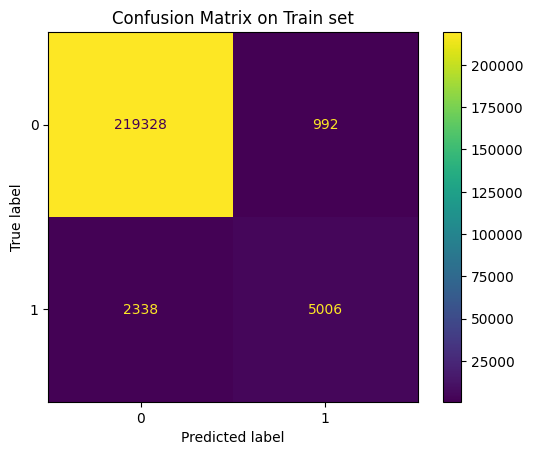

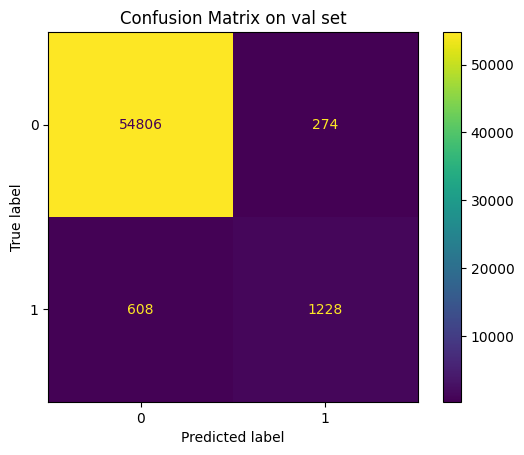

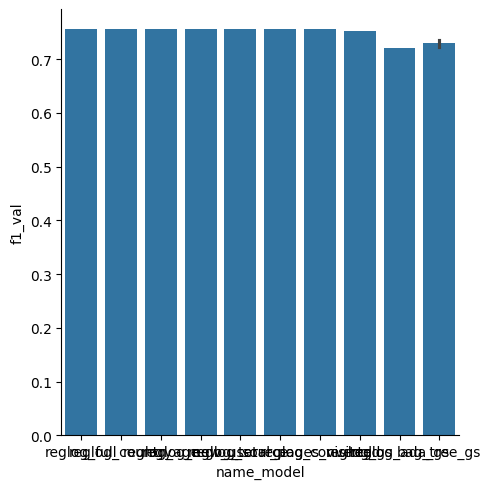

In [42]:
# Perform grid search
decision_tree = DecisionTreeClassifier()
bag_tree = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [2, 3, 4, 5],
    'base_estimator__min_samples_leaf': [1, 2],
    'base_estimator__min_samples_split': [2, 3],
    'n_estimators': [3, 4, 5]
}
print(params)
bag_tree_gs2 = GridSearchCV(bag_tree, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
bag_tree_gs2.fit(X_train, y_train)

bag_tree_gs2 = model_scores('bag_tree_gs', bag_tree_gs2.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,bag_tree_gs2])
print(f'bagtree_best_params = {bag_tree_gs2.parametres[0]}')

#1. 'estimator__criterion': 'gini', estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 4
# 2estimator__criterion': 'gini', 'estimator__max_depth': 5,'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'n_estimators': 3
# les 2 sont identiques....

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

In [45]:
len(X_train) #227664 ok.

227664

In [ ]:

ada_tree = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

In [ ]:
### XGBoost: # que decision trees

reglog_xg = GradientBoostingClassifier(logistic_regression)



In [131]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False) 

In [ ]:

classification_report

from sklearn.tree import plot_tree

class_names = encoder.inverse_transform([0, 1, 2])

plt.figure(figsize=(20,20))
a = plot_tree(classifier_gini, 
              feature_names=X.columns, 
              class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**